In [2]:
import pandas as pd
import numpy as np
import os
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score
from statsmodels.stats.multitest import multipletests
%load_ext autoreload
%autoreload 2

In [3]:
def compute_roc_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return roc_auc


def compute_pr_auc(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    pr_auc = auc(recall, precision)
    return pr_auc


def plot_roc_curve(y_true, y_pred, label, ax):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    sns.lineplot(fpr, tpr, lw=1, ax=ax, alpha=0.3, label="{} - AUC: %0.2f".format(label) % (roc_auc))


def plot_pr_curve(y_true, y_pred, label, ax):
    precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    pr_auc = auc(recall, precision)
    sns.lineplot(recall, precision, lw=1, alpha=0.3, ax=ax, label="{} - AUC: %0.2f".format(label) % (pr_auc))
    
def customise_roc_pr_plots(axes, label_size=15, font_size=15, linewidth=5, patch_size=20):
    # Customizing plots
    for ax in axes:
        ax.xaxis.label.set_size(label_size)
        ax.yaxis.label.set_size(label_size)

        for axis in [ax.xaxis, ax.yaxis]:
            for tick in axis.get_major_ticks():
                tick.label.set_fontsize(font_size)

        plt.setp(ax.get_legend().get_texts(), fontsize='{}'.format(font_size))
        plt.setp(ax.lines, linewidth=linewidth)

    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')

    for ax in axes:
        for axis in [ax.xaxis, ax.yaxis]:
            axis.label.set_size(font_size)

    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')

    for ax in axes:
        ax.legend(loc='best', prop={'size': patch_size})

In [37]:
from pyensembl import Genome
from multiprocessing import Pool
from tqdm.notebook import tqdm
from itertools import product


def add_chromosome_and_gene_info(info_df):
    info_df["chr"] = info_df["transcript_id"].apply(lambda x: chr_map[genome.transcript_by_id(x).contig])
    info_df["gene_id"] = info_df["transcript_id"].apply(lambda x: genome.transcript_by_id(x).gene_id)
    return info_df


def _add_genomic_position(task):
    tx, tx_df = task
    gt_map = pd.read_csv(os.path.join(gt_dir, tx, "gt_mapping.csv.gz")).set_index("tx_pos")
    tx_df["genomic_position"] = gt_map["g_pos"].loc[tx_df["transcript_position"]].values
    tx_df["kmer"] = gt_map["kmer"].loc[tx_df["transcript_position"]].values
    return tx_df


def add_genomic_position(info_df, n_jobs=25):
    with Pool(n_jobs) as p:
        tasks = ((tx, df) for tx, df in info_df.groupby("transcript_id"))
        n_transcripts = len(info_df.transcript_id.unique())
        res_df = [x for x in tqdm(p.imap_unordered(_add_genomic_position, tasks), total=n_transcripts)]
    return pd.concat(res_df).reset_index(drop=True)

chrsm_annot_dir = "/data03/christopher/annotations/chrsm_annot.txt"
genome = Genome(reference_name='GRCh38',
            annotation_name='my_genome_features',
            gtf_path_or_url='/data03/christopher/annotations/Homo_sapiens.GRCh38.91.chr_patch_hapl_scaff.gtf',
            transcript_fasta_paths_or_urls='/data03/christopher/annotations/Homo_sapiens.GRCh38.cdna.ncrna.fa') 
chr_map = {}
with open(chrsm_annot_dir) as f:
    for line in f:
        ensembl, ucsc = line.strip("\n").split("\t")
        chr_map[ensembl] = ucsc

gt_dir = "/data03/christopher/gt_mapping_final/"

NUM_NEIGHBORING_FEATURES = 1
CENTER_MOTIFS = [['A', 'G', 'T'], ['G', 'A'], ['A'], ['C'], ['A', 'C', 'T']]
ALL_KMERS = list(["".join(x) for x in product(*(CENTER_MOTIFS))])

In [41]:
model_results = "/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T_directRNA_Rep2/"
df = []

df = None
for model in ['prod_pooling']:
        model_dir = os.path.join(model_results, model)
        result = pd.read_csv(os.path.join(model_dir, "data.result.csv"))
        result = add_chromosome_and_gene_info(result)
        result = add_genomic_position(result)

        label = pd.read_csv(os.path.join(model_results, "data.readcount.labelled"))

        result = pd.merge(result, label, on=["gene_id", "genomic_position",
                                             "transcript_id", "transcript_position"])
        result = result[["gene_id", "genomic_position", "transcript_id", "transcript_position", 
                        "probability_modified", "modification_status"]]

        result = result.rename({'probability_modified': "probability_modified_{}".format(model)}, axis=1)
        if df is None:
            df = result
        else:
            df = df.merge(result, on=["transcript_id", "transcript_position"])

epinano_dir = "/data03/christopher/epinano_svm_results"
for model in os.listdir(epinano_dir):
    model_name = model.split(".csv")[0]
    epinano_df = pd.read_csv(os.path.join(epinano_dir, model),
                             usecols=["#Kmer", "Window", "Ref", "ProbM"])
    epinano_df = epinano_df.rename({'#Kmer': 'kmer', 'Window': 'transcript_position', 'Ref': 'transcript_id'}, 
                                   axis=1)
    epinano_df["transcript_position"] = epinano_df["transcript_position"].apply(lambda x: int(x.split(":")[1]))
    epinano_df["transcript_id"] = epinano_df["transcript_id"].apply(lambda x: x.split(".")[0])
    epinano_df = epinano_df.rename({'#Kmer': 'kmer', 'Window': 'transcript_position', 'Ref': 'transcript_id',
                                    'ProbM': "probability_modified_{}".format(model_name)}, axis=1)
    epinano_df = epinano_df[epinano_df["kmer"].isin(ALL_KMERS)].reset_index(drop=True)
    epinano_df = epinano_df[["transcript_id", "transcript_position", "probability_modified_{}".format(model_name)]]
    df = df.merge(epinano_df, on=["transcript_id", "transcript_position"])
    
df = df.rename({'probability_modified_prod_pooling_pr_auc': 'probability_modified_prod_pooling_attention',
           'probability_modified_prod_pooling_regularized': 'probability_modified_prod_pooling'}, axis=1)

df = df.rename({'gene_id_x': 'gene_id',
                'genomic_position_x': 'genomic_position',
                'modification_status_x': 'modification_status'}, axis=1)

  0%|          | 0/4662 [00:00<?, ?it/s]

In [89]:
mines_results = pd.read_csv("/data03/christopher/mines_output/m6A_output_mines.bed", delimiter="\t",
                            names=["kmer", "window", "strand", 
                                   "probability_modified_MINES", "n_reads"]).reset_index()\
                    .rename({'level_0': 'transcript_id', 'level_1': 'start', 'level_2': 'end'}, 
                            axis=1)
mines_results["transcript_id"] = mines_results["transcript_id"].apply(lambda x: x.split(".")[0])
mines_results["transcript_position"] = mines_results["start"] - 1
mines_results = add_chromosome_and_gene_info(mines_results)
mines_results = add_genomic_position(mines_results)


  0%|          | 0/9540 [00:00<?, ?it/s]

In [93]:
result_df_mines_agg = mines_results.groupby(["gene_id", "genomic_position"]).mean()
result_df_agg = result_df_agg.merge(result_df_mines_agg, 
                              on=["genomic_position", "gene_id"])

m6Anet


/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


EpiNano_SVM20_model1


/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


EpiNano_SVM20_model2


/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


EpiNano_SVM100_model1


/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


EpiNano_SVM100_model2


/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


MINES


/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


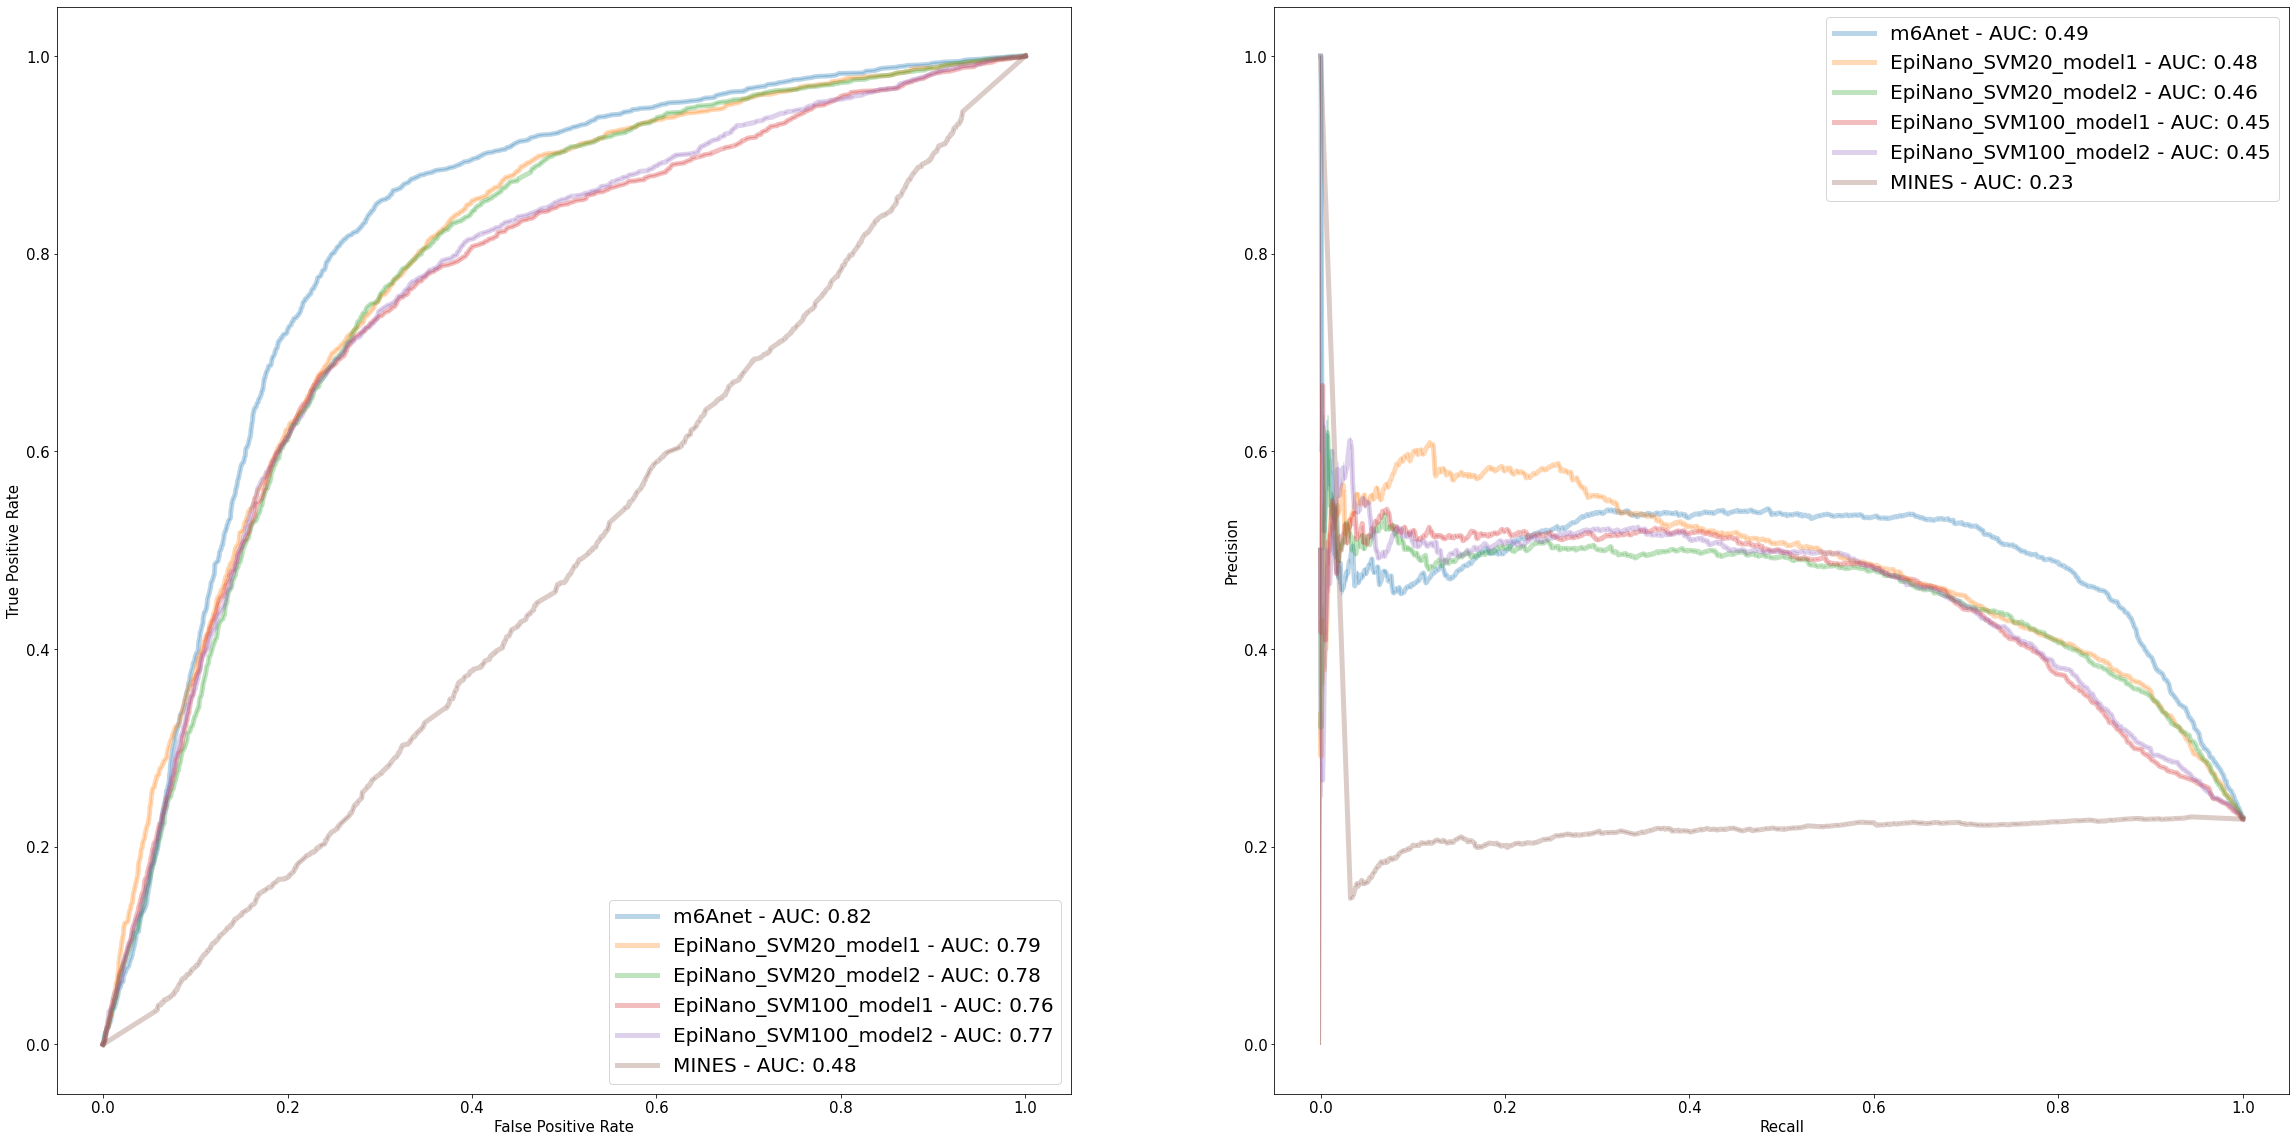

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(40, 20))
result_df_agg = df.groupby(["gene_id", "genomic_position"]).mean()
result_df_mines_agg = mines_results.groupby(["gene_id", "genomic_position"]).mean()
result_df_agg = result_df_agg.merge(result_df_mines_agg, on=["genomic_position", "gene_id"])

for model, col in zip(["m6Anet", "EpiNano_SVM20_model1", "EpiNano_SVM20_model2", "EpiNano_SVM100_model1", 
                       "EpiNano_SVM100_model2", "MINES"], ["probability_modified_prod_pooling",
                                                  "probability_modified_SVM20_model1",
                                                  "probability_modified_SVM20_model2",
                                                  "probability_modified_SVM100_model1",
                                                  "probability_modified_SVM100_model2",
                                                  "probability_modified_MINES"]):
    y_true, y_pred = result_df_agg["modification_status"].values, result_df_agg[col].values
    print(model)
    plot_roc_curve(y_true, y_pred, model, axes[0])
    plot_pr_curve(y_true, y_pred, model, axes[1])
customise_roc_pr_plots(axes)


m6Anet


/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


EpiNano_SVM20_model1


/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


EpiNano_SVM20_model2


/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


EpiNano_SVM100_model1


/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


EpiNano_SVM100_model2


/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


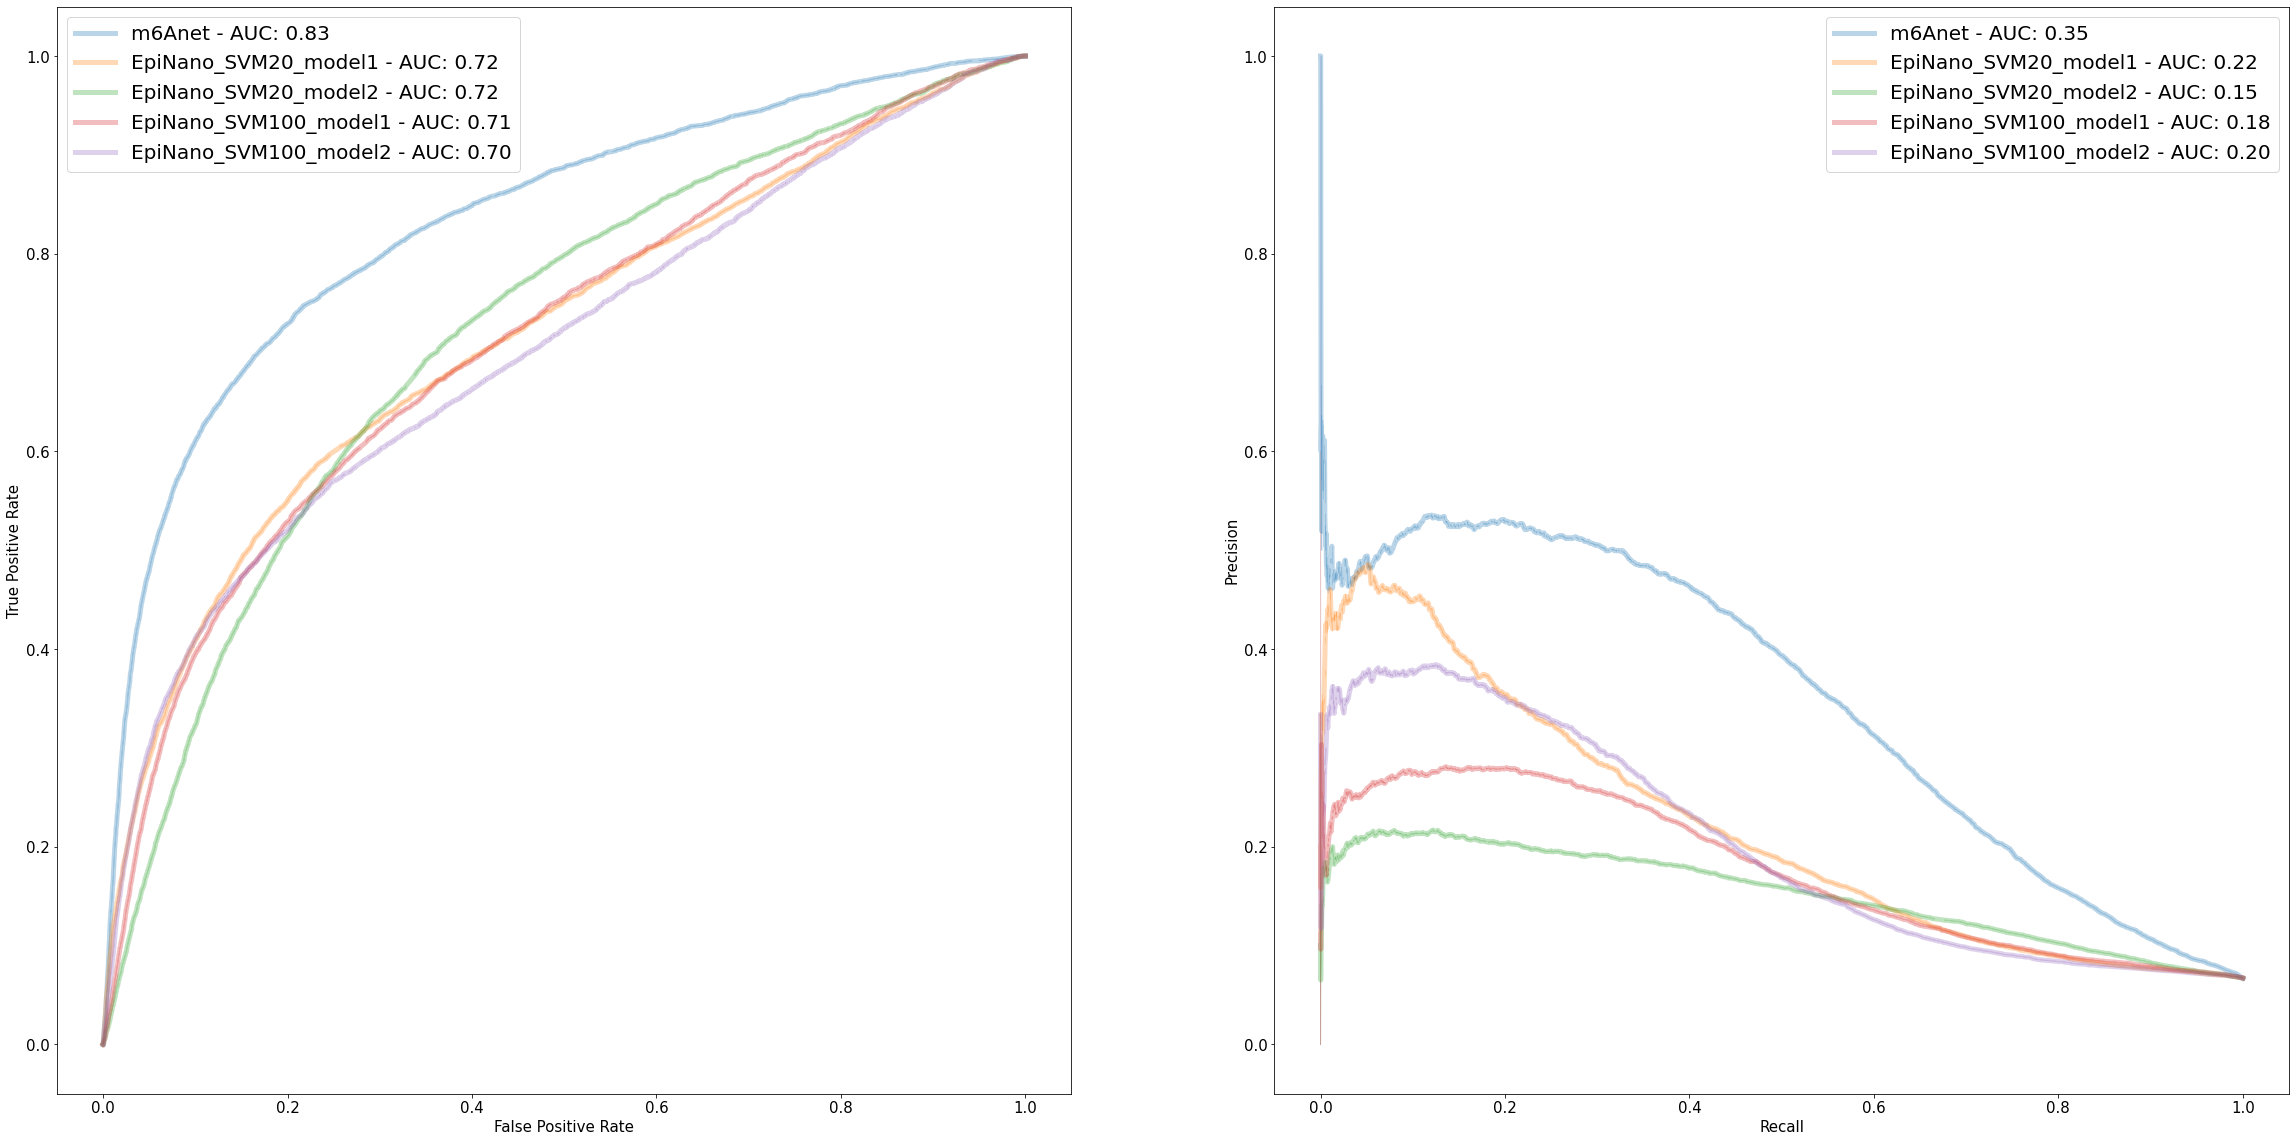

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(40, 20))
result_df_agg = df.groupby(["gene_id", "genomic_position"]).mean()
for model, col in zip(["m6Anet", "EpiNano_SVM20_model1", "EpiNano_SVM20_model2", "EpiNano_SVM100_model1", 
                       "EpiNano_SVM100_model2"], ["probability_modified_prod_pooling",
                                                  "probability_modified_SVM20_model1",
                                                  "probability_modified_SVM20_model2",
                                                  "probability_modified_SVM100_model1",
                                                  "probability_modified_SVM100_model2"]):
    y_true, y_pred = result_df_agg["modification_status"].values, result_df_agg[col].values
    print(model)
    plot_roc_curve(y_true, y_pred, model, axes[0])
    plot_pr_curve(y_true, y_pred, model, axes[1])
customise_roc_pr_plots(axes)


In [106]:
ko_table = pd.read_csv("/data03/christopher/wt_ko_hek293_ttest/ttest_results.csv.gz")
alpha = 0.005
result_df_agg = df.groupby(["gene_id", "genomic_position"]).mean()
result_df_agg = result_df_agg.merge(ko_table, on=["gene_id", "genomic_position"])
result_df_agg["pvalue"] = multipletests(result_df_agg.pvalue, alpha=alpha, method='fdr_bh')[1]


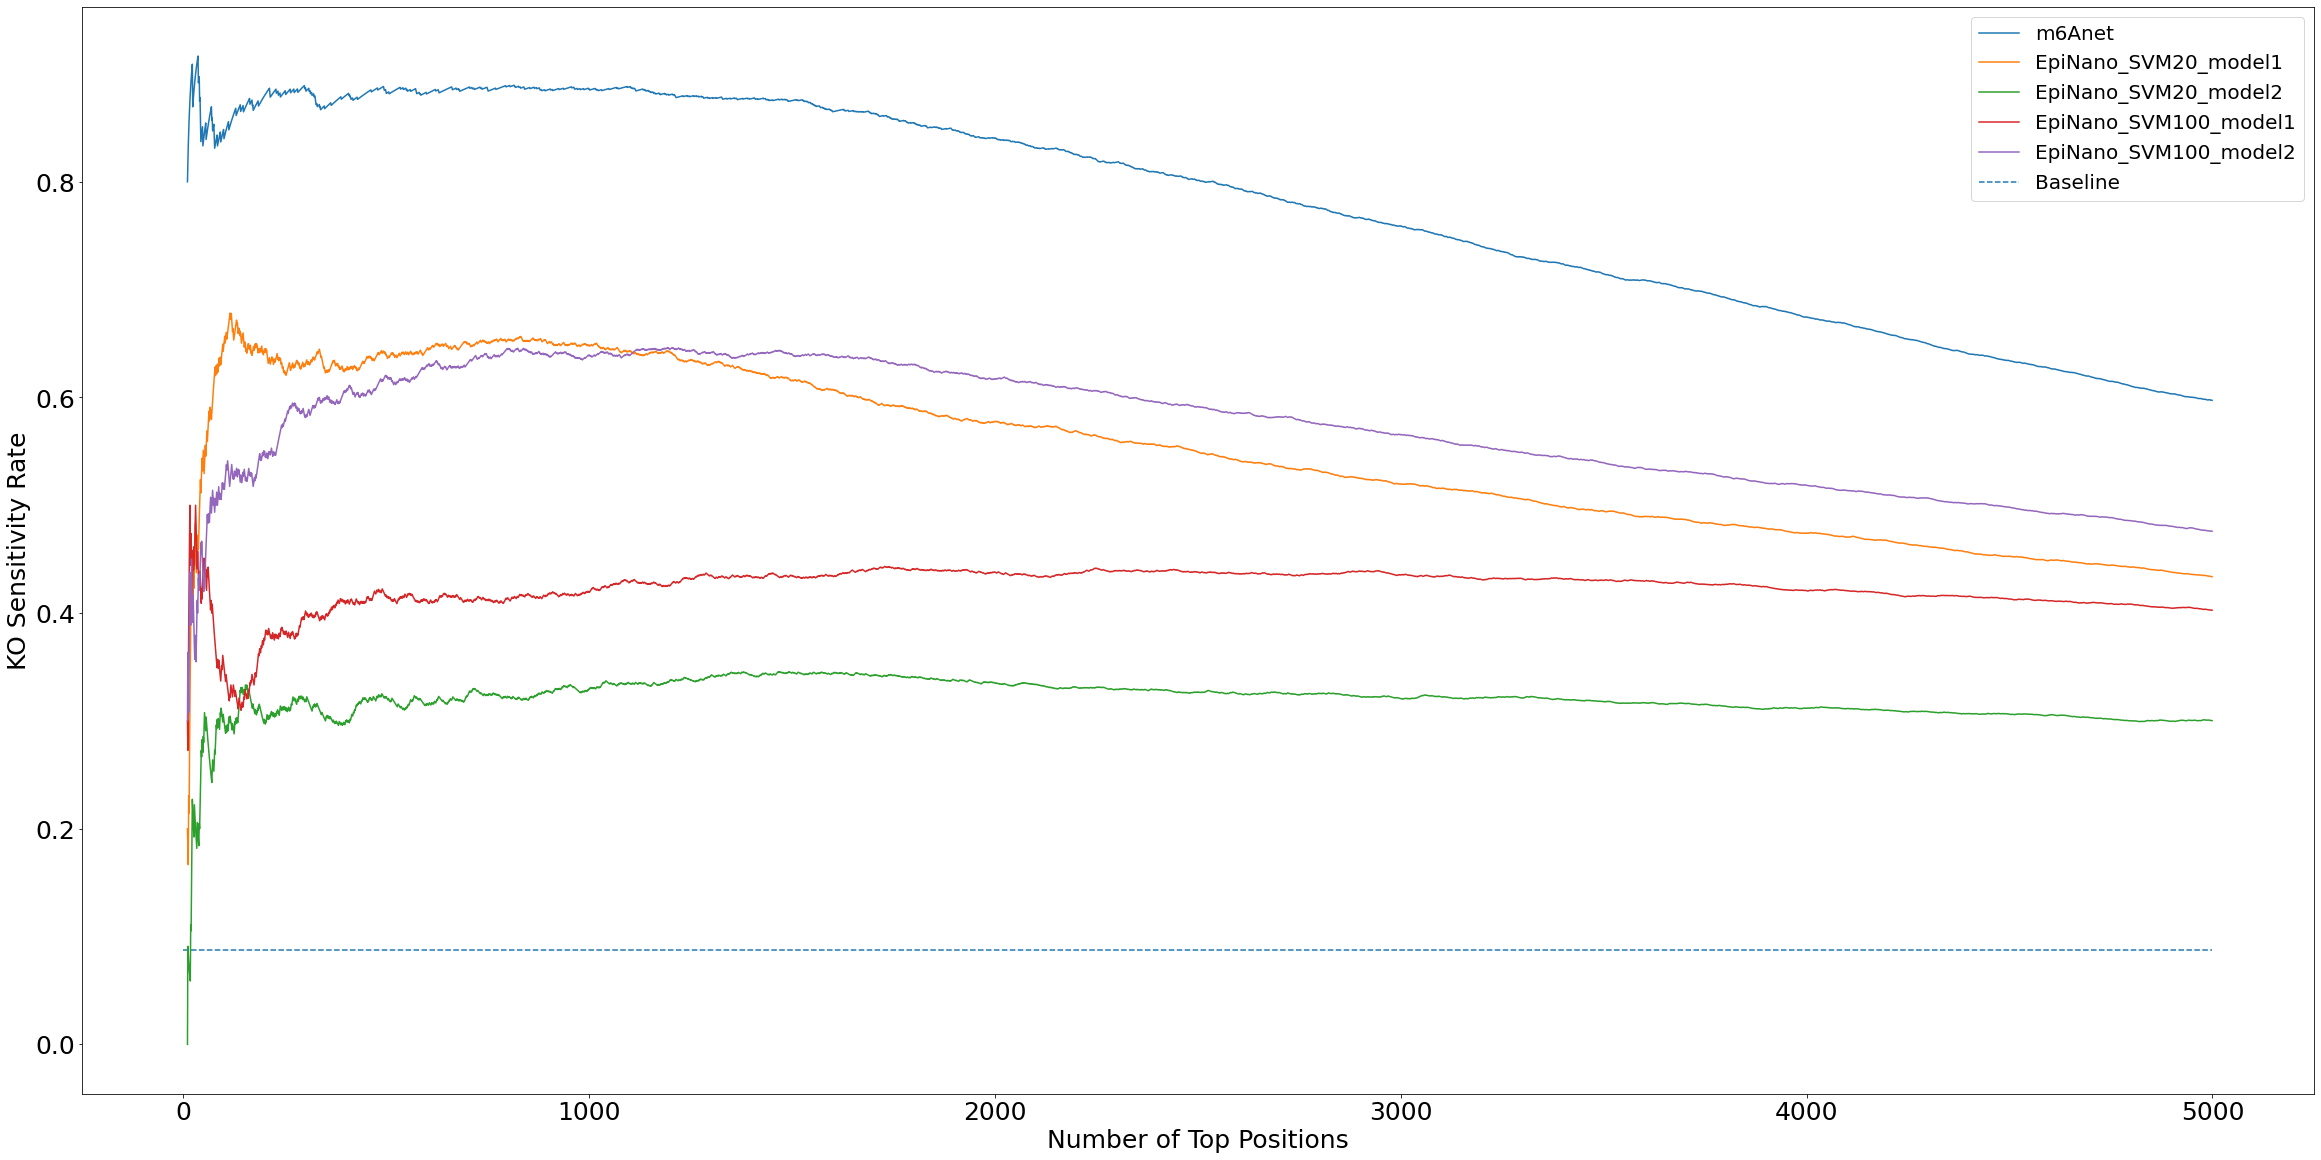

In [146]:
top_n = np.arange(10, 5000)
result_df_agg["ko_sens"] = (to_plot["pvalue"] < 0.05) * 1

fig, ax = plt.subplots(1, 1, figsize=(40, 20))
for model, col in zip(["m6Anet", "EpiNano_SVM20_model1", "EpiNano_SVM20_model2", "EpiNano_SVM100_model1", 
                       "EpiNano_SVM100_model2"], ["probability_modified_prod_pooling",
                                                  "probability_modified_SVM20_model1",
                                                  "probability_modified_SVM20_model2",
                                                  "probability_modified_SVM100_model1",
                                                  "probability_modified_SVM100_model2"]):
    to_plot = result_df_agg.sort_values(col, ascending=False)
    ko_sensitivities = [to_plot["ko_sens"].head(n=n).mean() for n in top_n]
    sns.lineplot(x=top_n, y=ko_sensitivities, label=model, ax=ax)

baseline = result_df_agg["ko_sens"].mean()

ax.hlines(baseline, xmin=0, xmax=5000, linestyles="--", label="Baseline")
plt.legend()

label_size = 25
font_size = 25
patch_size = 20
ax.xaxis.label.set_size(label_size)
ax.yaxis.label.set_size(label_size)

for axis in [ax.xaxis, ax.yaxis]:
    for tick in axis.get_major_ticks():
        tick.label.set_fontsize(font_size)

    plt.setp(ax.get_legend().get_texts(), fontsize='{}'.format(font_size))

ax.set_xlabel('Number of Top Positions')
ax.set_ylabel('KO Sensitivity Rate')

for axis in [ax.xaxis, ax.yaxis]:
    axis.label.set_size(font_size)


ax.legend(loc='best', prop={'size': patch_size})

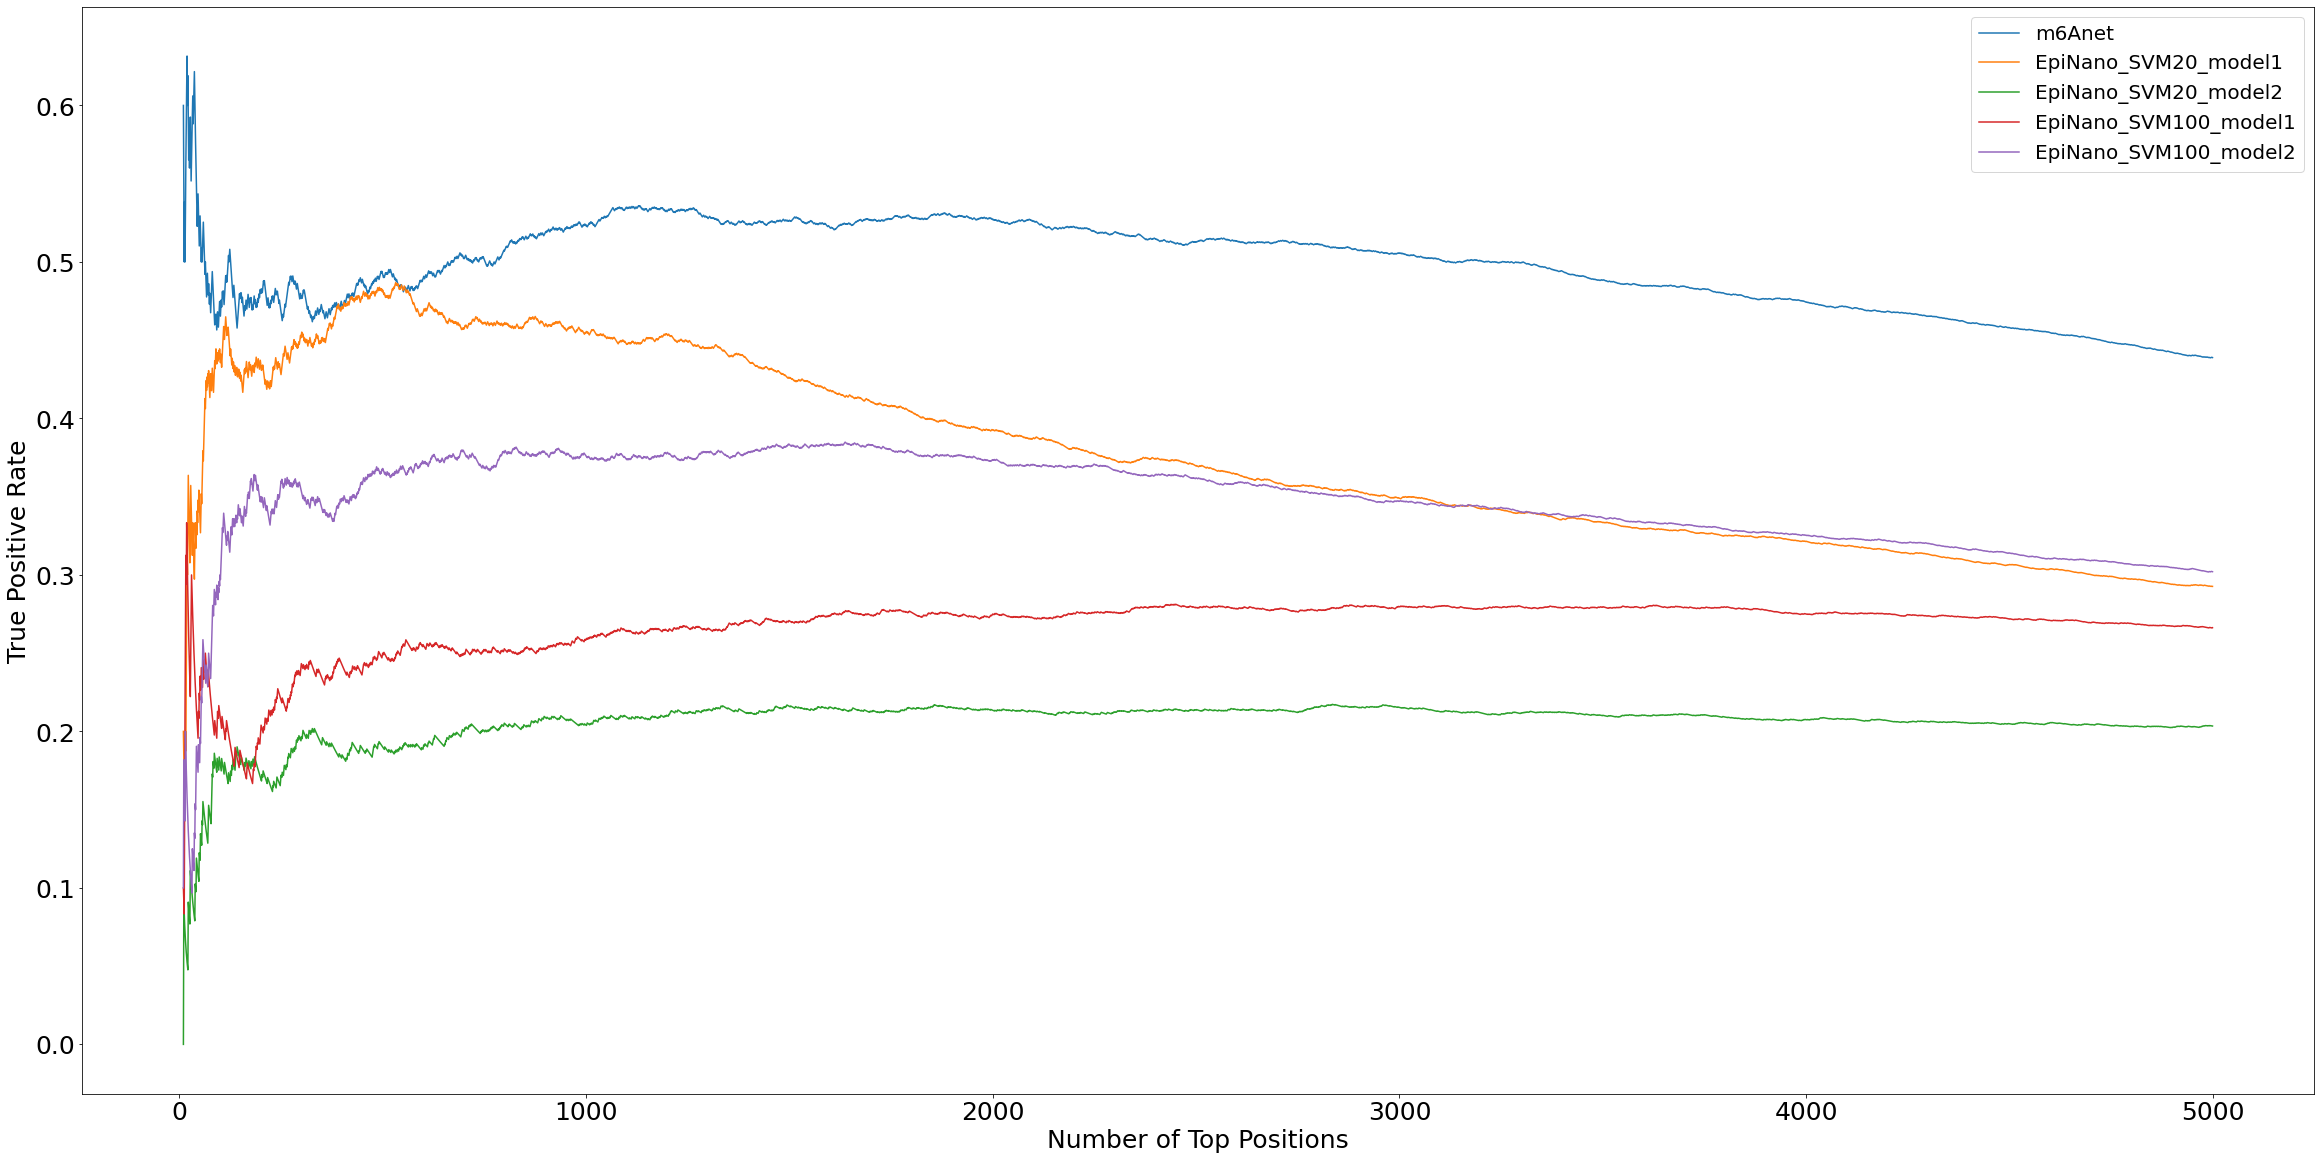

In [156]:
top_n = np.arange(10, 5000)
result_df_agg["ko_sens"] = (to_plot["pvalue"] < 0.05) * 1

fig, ax = plt.subplots(1, 1, figsize=(40, 20))
for model, col in zip(["m6Anet", "EpiNano_SVM20_model1", "EpiNano_SVM20_model2", "EpiNano_SVM100_model1", 
                       "EpiNano_SVM100_model2"], ["probability_modified_prod_pooling",
                                                  "probability_modified_SVM20_model1",
                                                  "probability_modified_SVM20_model2",
                                                  "probability_modified_SVM100_model1",
                                                  "probability_modified_SVM100_model2"]):
    to_plot = result_df_agg.sort_values(col, ascending=False)
    
    modification_status = to_plot["modification_status"].values
    
    tpr = np.array([np.mean((modification_status[:n]))for n in top_n])
    sns.lineplot(x=top_n, y=tpr, label=model, ax=ax)


plt.legend()

label_size = 25
font_size = 25
patch_size = 20
ax.xaxis.label.set_size(label_size)
ax.yaxis.label.set_size(label_size)

for axis in [ax.xaxis, ax.yaxis]:
    for tick in axis.get_major_ticks():
        tick.label.set_fontsize(font_size)

    plt.setp(ax.get_legend().get_texts(), fontsize='{}'.format(font_size))

ax.set_xlabel('Number of Top Positions')
ax.set_ylabel('True Positive Rate')

for axis in [ax.xaxis, ax.yaxis]:
    axis.label.set_size(font_size)


ax.legend(loc='best', prop={'size': patch_size})

In [160]:
result_df_agg

,gene_id,genomic_position,transcript_position,probability_modified_prod_pooling,modification_status,probability_modified_SVM20_model1,probability_modified_SVM20_model2,probability_modified_SVM100_model2,probability_modified_SVM100_model1,pvalue,ko_sens
0,ENSG00000000003,100629726,1149.0,0.019846,0.0,2.644332e-01,0.596400,8.584801e-02,0.075028,0.583339,0
1,ENSG00000000003,100629744,1131.0,0.007654,0.0,2.209386e-06,0.079654,4.520797e-03,0.000003,0.840125,0
2,ENSG00000000003,100629862,1013.0,0.321211,0.0,1.256766e-01,0.615340,1.277645e-01,0.173426,0.707710,0
3,ENSG00000000003,100629869,1006.0,0.135096,0.0,7.574388e-03,0.275607,7.186559e-02,0.086510,0.731998,0
4,ENSG00000000003,100629907,968.0,0.008265,0.0,6.020487e-01,0.671078,2.639955e-01,0.295994,0.260949,0
...,...,...,...,...,...,...,...,...,...,...,...
75300,ENSG00000284707,97864409,1556.0,0.030498,0.0,6.603126e-10,0.127321,6.522367e-07,0.000004,0.698018,0
75301,ENSG00000284707,97864429,1536.0,0.070821,0.0,2.658513e-01,0.292229,1.104188e-01,0.216702,0.400084,0
75302,ENSG00000284707,97864466,1499.0,0.121067,0.0,1.563887e-02,0.340493,1.908497e-01,0.200981,0.898043,0
75303,ENSG00000284707,97868996,1380.0,0.176175,0.0,7.750269e-02,0.289282,1.467804e-01,0.154937,0.932183,0


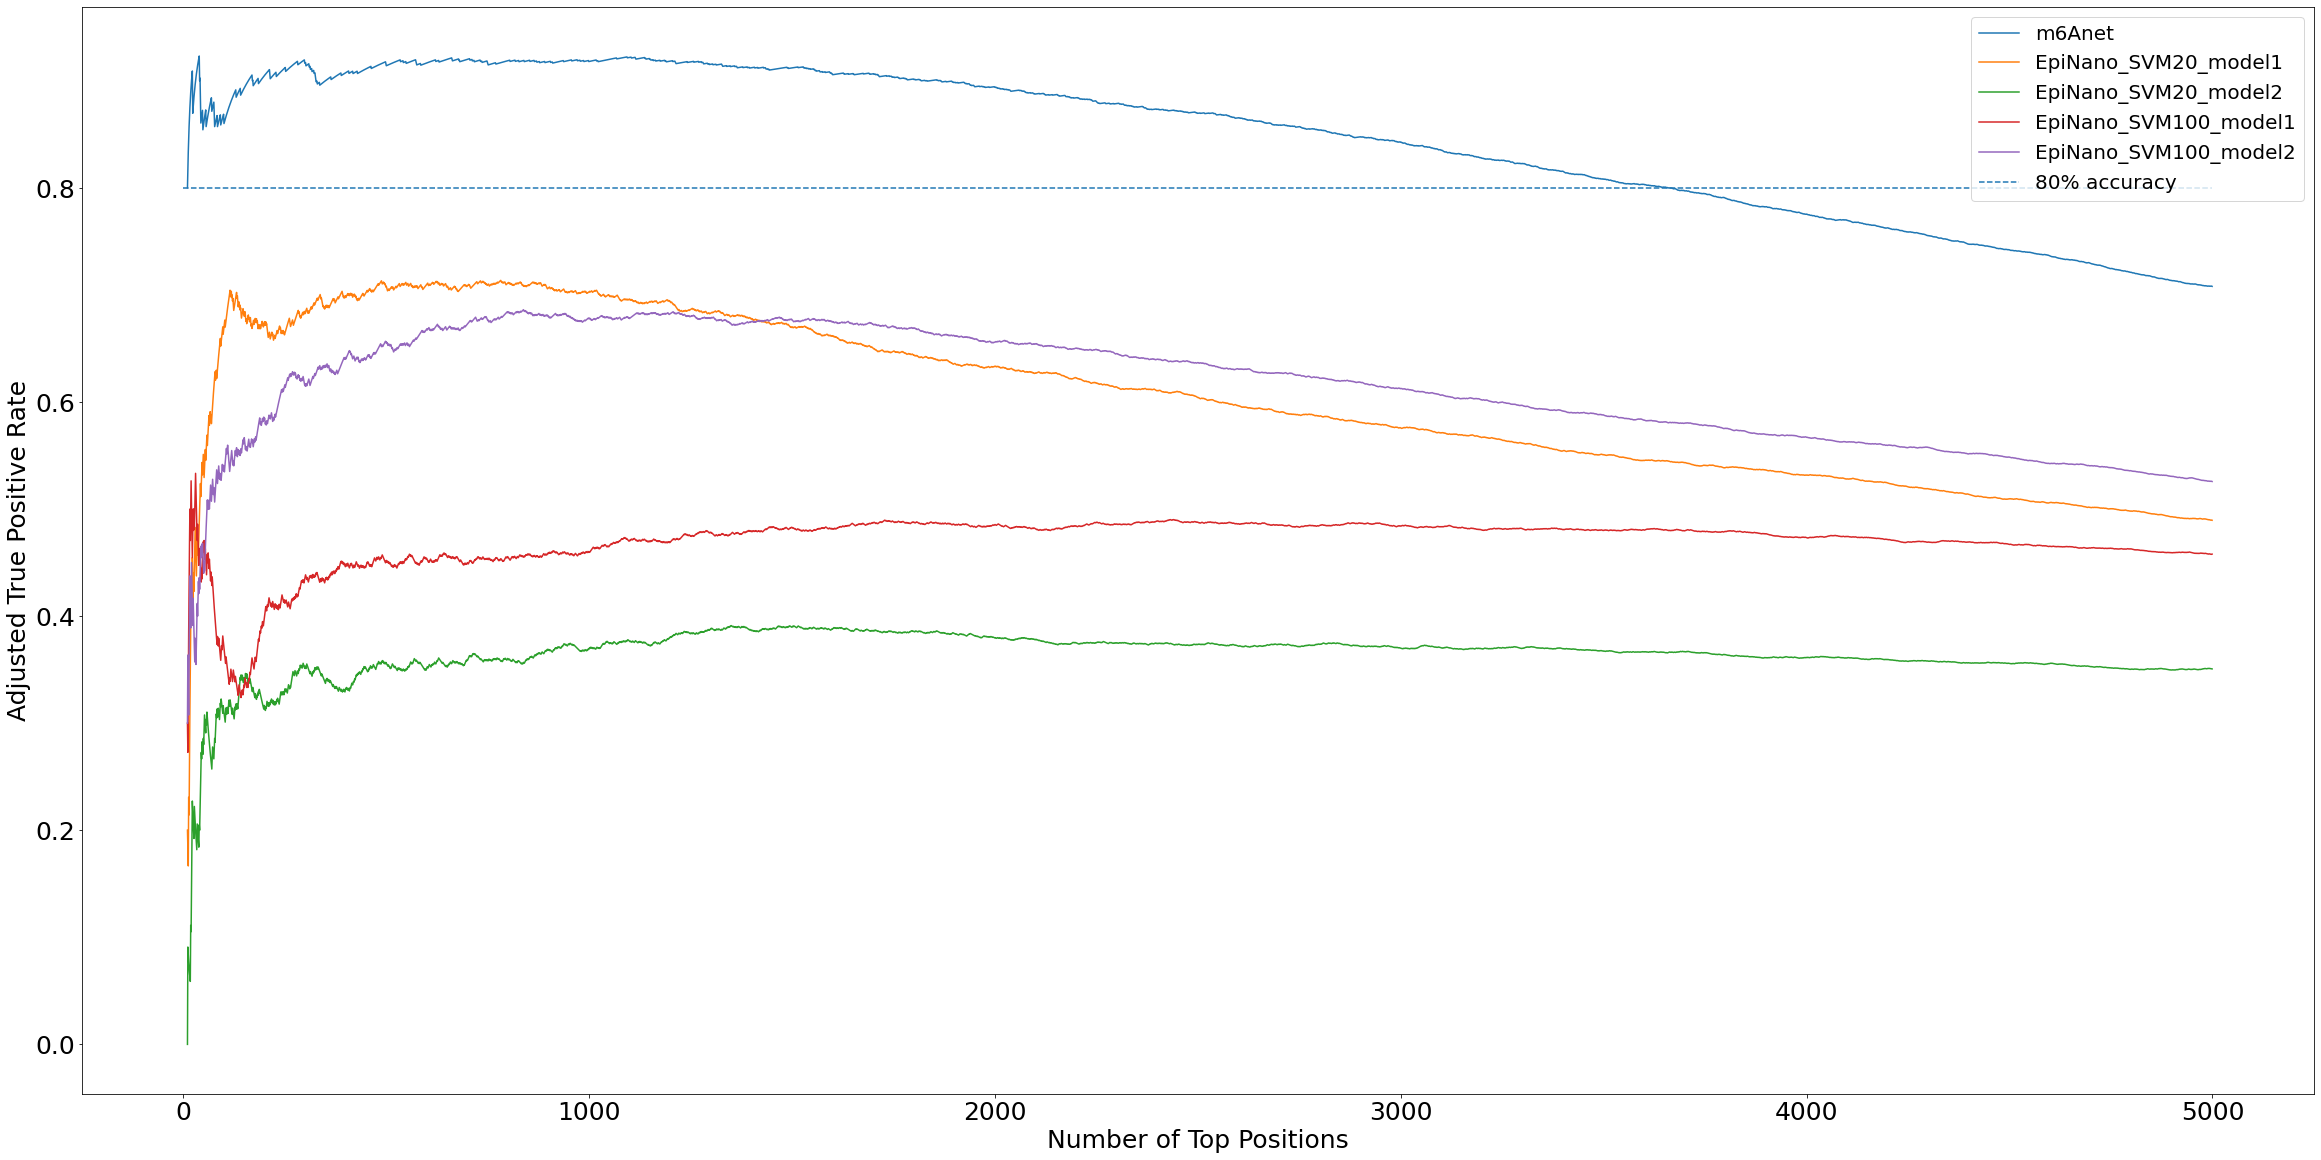

In [162]:
top_n = np.arange(10, 5000)
result_df_agg["ko_sens"] = (to_plot["pvalue"] < 0.05) * 1

fig, ax = plt.subplots(1, 1, figsize=(40, 20))
for model, col in zip(["m6Anet", "EpiNano_SVM20_model1", "EpiNano_SVM20_model2", "EpiNano_SVM100_model1", 
                       "EpiNano_SVM100_model2"], ["probability_modified_prod_pooling",
                                                  "probability_modified_SVM20_model1",
                                                  "probability_modified_SVM20_model2",
                                                  "probability_modified_SVM100_model1",
                                                  "probability_modified_SVM100_model2"]):
    to_plot = result_df_agg.sort_values(col, ascending=False)
    
    ko_sensitivities = to_plot["ko_sens"].values
    modification_status = to_plot["modification_status"].values
    
    adjusted_tpr = np.array([np.mean((np.logical_or(ko_sensitivities[:n], modification_status[:n]))) for n in top_n])
    
    sns.lineplot(x=top_n, y=adjusted_tpr, label=model, ax=ax)
    
ax.hlines(0.8, xmin=0, xmax=5000, linestyles="--", label="80% accuracy")
plt.legend()

label_size = 25
font_size = 25
patch_size = 20
ax.xaxis.label.set_size(label_size)
ax.yaxis.label.set_size(label_size)

for axis in [ax.xaxis, ax.yaxis]:
    for tick in axis.get_major_ticks():
        tick.label.set_fontsize(font_size)

    plt.setp(ax.get_legend().get_texts(), fontsize='{}'.format(font_size))

ax.set_xlabel('Number of Top Positions')
ax.set_ylabel('Adjusted True Positive Rate')

for axis in [ax.xaxis, ax.yaxis]:
    axis.label.set_size(font_size)


ax.legend(loc='best', prop={'size': patch_size})